In [2]:
#Download the dataset from opensig
import urllib.request
urllib.request.urlretrieve('http://opendata.deepsig.io/datasets/2016.10/RML2016.10a.tar.bz2', 'RML2016.10a.tar.bz2')

('RML2016.10a.tar.bz2', <http.client.HTTPMessage at 0x7fdd2c814908>)

In [0]:
#decompress the .bz2 file into .tar file
import sys
import os
import bz2
zipfile = bz2.BZ2File('./RML2016.10a.tar.bz2') # open the file
data = zipfile.read() # get the decompressed data

In [4]:
#write the .tar file
open('./RML2016.10a.tar', 'wb').write(data) # write a uncompressed file

640952320

In [0]:
#extract the .tar file
import tarfile
my_tar = tarfile.open('./RML2016.10a.tar')
my_tar.extractall('./') # specify which folder to extract to
my_tar.close()

In [0]:
#extract the pickle file
import pickle
import numpy as np
Xd = pickle.load(open("RML2016.10a_dict.pkl",'rb'),encoding="bytes")
snrs,mods = map(lambda j: sorted(list(set(map(lambda x: x[j], Xd.keys())))), [1,0])
X = []  
lbl = []
for mod in mods:
    for snr in snrs:
        X.append(Xd[(mod,snr)])
        for i in range(Xd[(mod,snr)].shape[0]):  lbl.append((mod,snr))
X = np.vstack(X)

In [7]:
# Import all the things we need ---
%matplotlib inline
import random
import tensorflow.keras.utils
import tensorflow.keras.models as models
from tensorflow.keras.layers import Reshape,Dense,Dropout,Activation,Flatten
from tensorflow.keras.layers import GaussianNoise
from tensorflow.keras.layers import Convolution2D, MaxPooling2D, ZeroPadding2D
from tensorflow.keras.regularizers import *
from tensorflow.keras.optimizers import *
import matplotlib.pyplot as plt
import seaborn as sns
import tensorflow.keras

/usr/local/lib/python3.6/dist-packages/statsmodels/tools/_testing.py:19: FutureWarning: pandas.util.testing is deprecated. Use the functions in the public API at pandas.testing instead.
  import pandas.util.testing as tm


In [0]:
# Partition the data
#  into training and test sets of the form we can train/test on 
np.random.seed(2020)
n_examples = X.shape[0]
n_train = n_examples // 2
train_idx = np.random.choice(range(0,n_examples), size=n_train, replace=False)
test_idx = list(set(range(0,n_examples))-set(train_idx))
X_train = X[train_idx]
X_test =  X[test_idx]

In [9]:
#one-hot encoding the label
from sklearn import preprocessing
lb = preprocessing.LabelBinarizer()
lb.fit(np.asarray(lbl)[:,0])
# Print 11 different modulation techniques
print(lb.classes_)
lbl_encoded=lb.transform(np.asarray(lbl)[:,0])
y_train=lbl_encoded[train_idx]                #(110000, 11)
y_test=lbl_encoded[test_idx]               #(110000, 11)

[b'8PSK' b'AM-DSB' b'AM-SSB' b'BPSK' b'CPFSK' b'GFSK' b'PAM4' b'QAM16'
 b'QAM64' b'QPSK' b'WBFM']


In [10]:
in_shp = list(X_train.shape[1:])
print(X_train.shape, in_shp)
classes = mods

(110000, 2, 128) [2, 128]


In [11]:
dr = 0.5 # dropout rate (%)
model = models.Sequential()
#######  - Reshape [N,2,128] to [N,1,2,128] on input
model.add(Reshape(in_shp+[1], input_shape=in_shp)) 

model.add(ZeroPadding2D((0, 2),data_format = "channels_last"))
# 80 filters that have the size of 2 × 3 each
model.add(Convolution2D(filters = 80, kernel_size=(2, 3), activation="relu", name="conv1",data_format = "channels_last"))
model.add(Dropout(dr))
model.add(ZeroPadding2D((0, 2),data_format = "channels_last"))

# 256 filters with the size of 1 × 3 each
model.add(Convolution2D(filters = 256, kernel_size=(1, 3), activation="relu", name="conv2",data_format = "channels_last"))
model.add(Dropout(dr))
model.add(Flatten())

# the fully connected layers with 128 neurons
model.add(Dense(128, activation='relu', kernel_initializer = 'he_normal', name="dense1"))
model.add(Dropout(dr))

# the fully connected layers with 11 neurons
model.add(Dense( len(classes), kernel_initializer = 'he_normal',name="dense2" ))
model.add(Activation('softmax'))
model.add(Reshape([len(classes)]))
model.compile(loss='categorical_crossentropy', optimizer='adam')
model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
reshape (Reshape)            (None, 2, 128, 1)         0         
_________________________________________________________________
zero_padding2d (ZeroPadding2 (None, 2, 132, 1)         0         
_________________________________________________________________
conv1 (Conv2D)               (None, 1, 130, 80)        560       
_________________________________________________________________
dropout (Dropout)            (None, 1, 130, 80)        0         
_________________________________________________________________
zero_padding2d_1 (ZeroPaddin (None, 1, 134, 80)        0         
_________________________________________________________________
conv2 (Conv2D)               (None, 1, 132, 256)       61696     
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 132, 256)       0

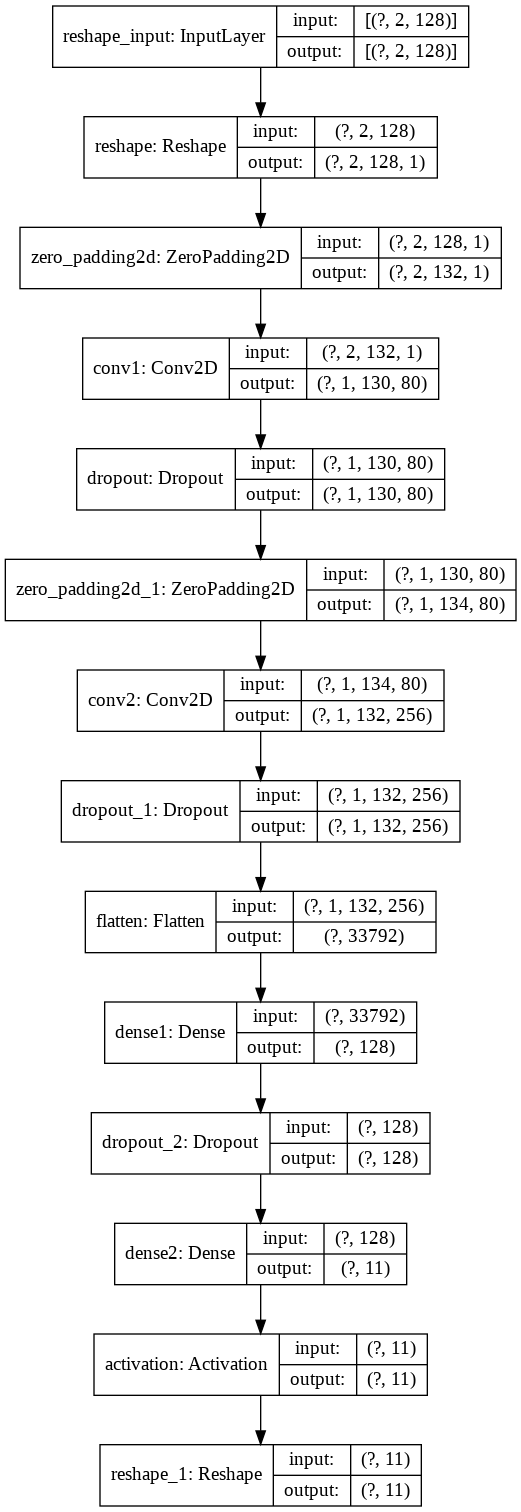

In [12]:
from tensorflow.keras.utils import plot_model

plot_model(model, show_shapes = True, to_file='model.png')

In [0]:
# Set up some params 
nb_epoch = 100     # number of epochs to train on
batch_size = 1024  # training batch size

In [14]:
from sklearn.model_selection import train_test_split
X_train, X_valid, y_train, y_valid = train_test_split(X_train, y_train, test_size=0.2)
print(X_train.shape)
print(y_train.shape)

print(X_valid.shape)
print(y_valid.shape)



(88000, 2, 128)
(88000, 11)
(22000, 2, 128)
(22000, 11)


In [15]:
# perform training ...
#   - call the main training loop in keras for our network+dataset
filepath = 'convmodrecnets_CNN2_0.5.wts.h5'
import time
t_0=time.time()

history = model.fit(X_train,
    y_train,
    batch_size=batch_size,
    epochs=nb_epoch,
    verbose=2,
    validation_data=(X_valid, y_valid),
    callbacks = [
        tensorflow.keras.callbacks.ModelCheckpoint(filepath, monitor='val_loss', verbose=0, save_best_only=True, mode='auto'),
        tensorflow.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5, verbose=0, mode='auto')
    ])
delta_t=time.time()-t_0
print(delta_t)
# we re-load the best weights once training is finished
model.load_weights(filepath)

Epoch 1/100
86/86 - 6s - loss: 2.3042 - val_loss: 2.2093
Epoch 2/100
86/86 - 6s - loss: 2.1722 - val_loss: 2.0863
Epoch 3/100
86/86 - 6s - loss: 2.0699 - val_loss: 1.9722
Epoch 4/100
86/86 - 6s - loss: 1.9952 - val_loss: 1.9221
Epoch 5/100
86/86 - 6s - loss: 1.9479 - val_loss: 1.8515
Epoch 6/100
86/86 - 6s - loss: 1.9027 - val_loss: 1.8228
Epoch 7/100
86/86 - 6s - loss: 1.8408 - val_loss: 1.7391
Epoch 8/100
86/86 - 6s - loss: 1.7939 - val_loss: 1.7021
Epoch 9/100
86/86 - 6s - loss: 1.7556 - val_loss: 1.6273
Epoch 10/100
86/86 - 6s - loss: 1.7292 - val_loss: 1.6308
Epoch 11/100
86/86 - 6s - loss: 1.7080 - val_loss: 1.5906
Epoch 12/100
86/86 - 6s - loss: 1.6960 - val_loss: 1.6147
Epoch 13/100
86/86 - 6s - loss: 1.6800 - val_loss: 1.6140
Epoch 14/100
86/86 - 6s - loss: 1.6680 - val_loss: 1.5718
Epoch 15/100
86/86 - 6s - loss: 1.6586 - val_loss: 1.5599
Epoch 16/100
86/86 - 6s - loss: 1.6438 - val_loss: 1.5264
Epoch 17/100
86/86 - 6s - loss: 1.6410 - val_loss: 1.5158
Epoch 18/100
86/86 - 6s

In [16]:
# Show simple version of performance
score = model.evaluate(X_test, y_test, verbose=0, batch_size=batch_size)
print(score)

1.3940081596374512


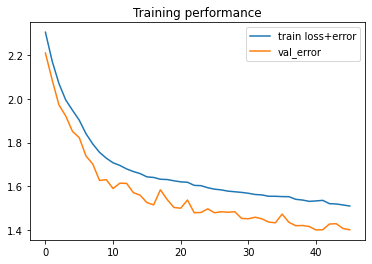

In [17]:
# Show loss curves 
plt.figure()
plt.title('Training performance')
plt.plot(history.epoch, history.history['loss'], label='train loss+error')
plt.plot(history.epoch, history.history['val_loss'], label='val_error')
plt.legend()

In [0]:
def plot_confusion_matrix(cm, title='Confusion matrix', cmap=plt.cm.Blues, labels=[]):
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(labels))
    plt.xticks(tick_marks, labels, rotation=45)
    plt.yticks(tick_marks, labels)
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

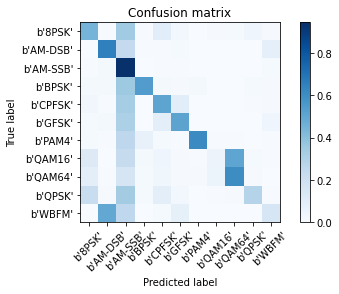

In [19]:
# Plot confusion matrix
test_Y_hat = model.predict(X_test, batch_size=batch_size)
conf = np.zeros([len(classes),len(classes)])
confnorm = np.zeros([len(classes),len(classes)])
for i in range(0,X_test.shape[0]):
    j = list(y_test[i,:]).index(1)
    k = int(np.argmax(test_Y_hat[i,:]))
    conf[j,k] = conf[j,k] + 1
for i in range(0,len(classes)): 
    confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
plot_confusion_matrix(confnorm, labels=classes)

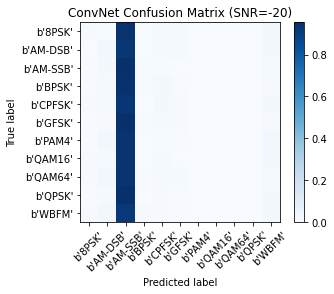

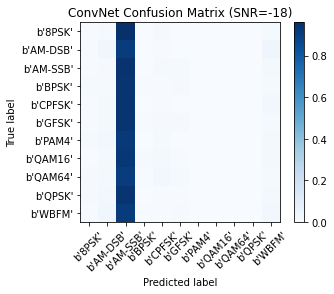

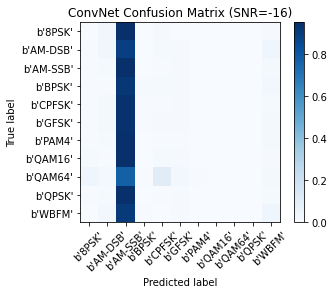

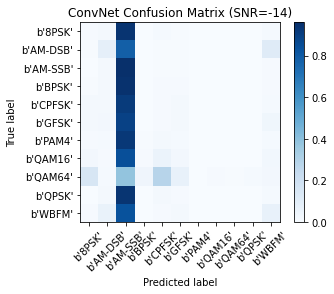

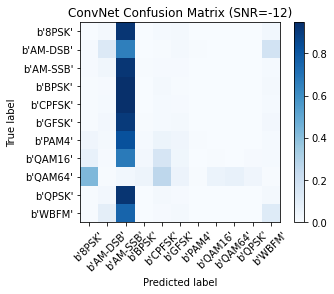

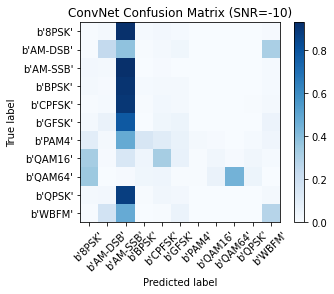

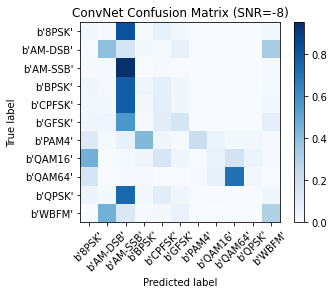

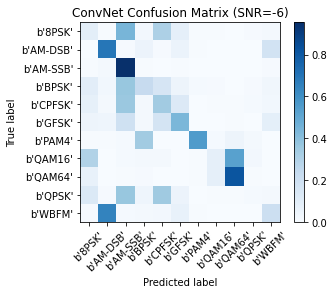

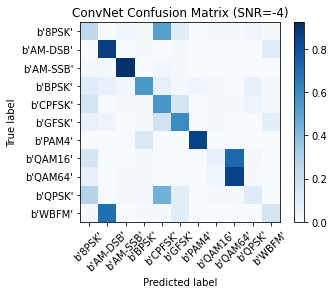

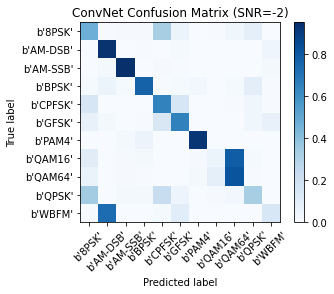

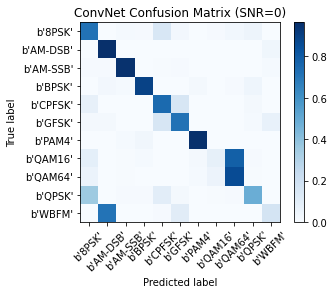

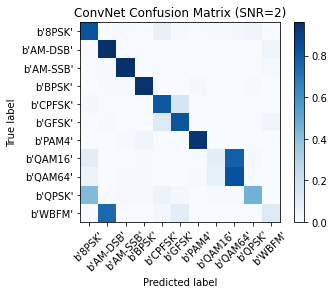

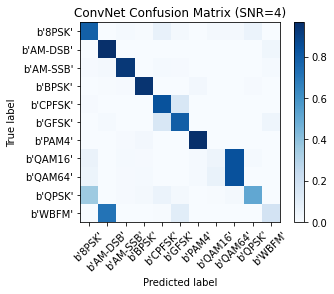

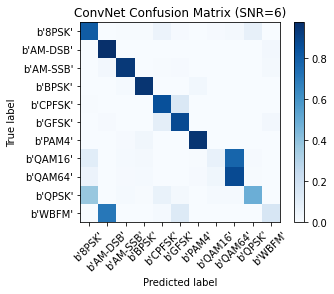

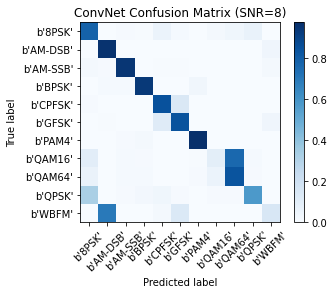

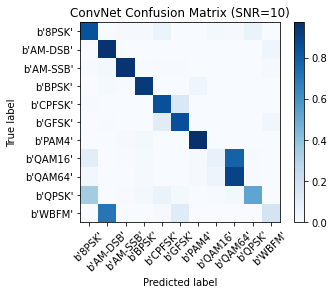

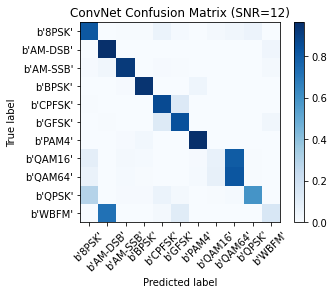

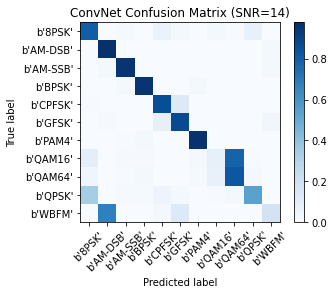

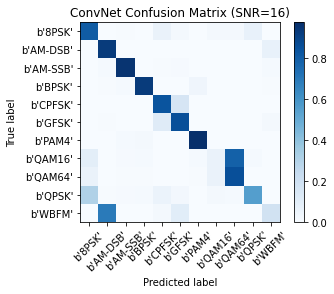

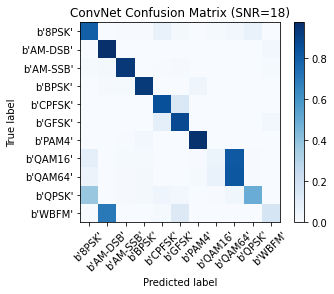

In [20]:
# Plot confusion matrix
acc = {}
for snr in snrs:

    # extract classes @ SNR
    test_SNRs = map(lambda x: lbl[x][1], test_idx)
    #print(snr)
    #print(np.array(list(test_SNRs)))
    #print(np.where(np.array(list(test_SNRs))==snr))
    
    mask = np.where(np.array(list(test_SNRs))==snr)
    #print("mask:{}".format(mask))
    test_X_i = X_test[mask]
    test_Y_i = y_test[mask] 
    
#     print(test_X_i.shape)
#     print(test_Y_i.shape)

    # estimate classes
    test_Y_i_hat = model.predict(test_X_i)
    #print(test_Y_i_hat)
    
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    
    for i in range(0,test_X_i.shape[0]):
        # print( list(test_Y_i[i,:]))
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1 
    
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    plt.figure(figsize = (5,4))
    plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    plt.savefig("../content/ Confusion Matrix SNR_{}.jpg".format(snr))
    
    cor = np.sum(np.diag(conf))
    #print(test_X_i)
    ncor = np.sum(conf) - cor
    acc[snr] = 1.0*cor/(cor+ncor)
    
   # print("Overall Accuracy: ", acc[snr])

In [21]:
# Get the test accuracy for different SNRs
acc = {}
acc_array=[]

snr_array=np.asarray(lbl)[:,1]
lb_temp = preprocessing.LabelBinarizer()
lb_temp.fit(snr_array)
temp_array=lb_temp.classes_
snr_label_array = []


snr_label_array.append(temp_array[6])
snr_label_array.append(temp_array[4])
snr_label_array.append(temp_array[3])
snr_label_array.append(temp_array[2])
snr_label_array.append(temp_array[1])
snr_label_array.append(temp_array[0])
snr_label_array.append(temp_array[9])
snr_label_array.append(temp_array[8])
snr_label_array.append(temp_array[7])
snr_label_array.append(temp_array[5])
snr_label_array.append(temp_array[10])
snr_label_array.append(temp_array[16])
snr_label_array.append(temp_array[17])
snr_label_array.append(temp_array[18])
snr_label_array.append(temp_array[19])
snr_label_array.append(temp_array[11])
snr_label_array.append(temp_array[12])
snr_label_array.append(temp_array[13])
snr_label_array.append(temp_array[14])
snr_label_array.append(temp_array[15])


#print(snr_label_array)
y_test_snr=snr_array[test_idx]



for snr in snr_label_array:
    test_X_i = X_test[np.where(y_test_snr==snr)]
    test_Y_i = y_test[np.where(y_test_snr==snr)]
    
    test_Y_i_hat = model.predict(test_X_i)
    conf = np.zeros([len(classes),len(classes)])
    confnorm = np.zeros([len(classes),len(classes)])
    for i in range(0,test_X_i.shape[0]):
        j = list(test_Y_i[i,:]).index(1)
        k = int(np.argmax(test_Y_i_hat[i,:]))
        conf[j,k] = conf[j,k] + 1
    for i in range(0,len(classes)):
        confnorm[i,:] = conf[i,:] / np.sum(conf[i,:])
    
    #plt.figure()
    #plot_confusion_matrix(confnorm, labels=classes, title="ConvNet Confusion Matrix (SNR=%d)"%(snr))
    
    cor = np.sum(np.diag(conf))
    ncor = np.sum(conf) - cor
    print("Overall Accuracy: ", cor / (cor+ncor),"for SNR",snr)
    acc[snr] = 1.0*cor/(cor+ncor)
    acc_array.append(1.0*cor/(cor+ncor))

print("Random Guess Accuracy:",1/11)

Overall Accuracy:  0.09357040229885058 for SNR b'-20'
Overall Accuracy:  0.09618543529841211 for SNR b'-18'
Overall Accuracy:  0.09790840245221781 for SNR b'-16'
Overall Accuracy:  0.10113386978785661 for SNR b'-14'
Overall Accuracy:  0.11331546023235031 for SNR b'-12'
Overall Accuracy:  0.18962663233400773 for SNR b'-10'
Overall Accuracy:  0.26849112426035504 for SNR b'-8'
Overall Accuracy:  0.3994153115293258 for SNR b'-6'
Overall Accuracy:  0.5258157045536035 for SNR b'-4'
Overall Accuracy:  0.611837327523602 for SNR b'-2'
Overall Accuracy:  0.6877986034546123 for SNR b'0'
Overall Accuracy:  0.7108127721335269 for SNR b'2'
Overall Accuracy:  0.7052150045745654 for SNR b'4'
Overall Accuracy:  0.7264722069345074 for SNR b'6'
Overall Accuracy:  0.7249190938511327 for SNR b'8'
Overall Accuracy:  0.7246841074924364 for SNR b'10'
Overall Accuracy:  0.7178226834152558 for SNR b'12'
Overall Accuracy:  0.7321201091901729 for SNR b'14'
Overall Accuracy:  0.7247037374658158 for SNR b'16'
Overa

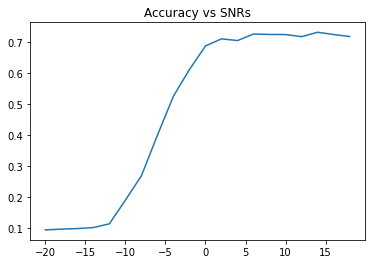

In [22]:
# Show loss curves 
plt.figure()
plt.title('Accuracy vs SNRs')
plt.plot(np.arange(-20,20,2), acc_array)